## Intro

Speech enhancemenet is the problem where a model takes in distorted (noisy) sound clip and cleans it up.

Usually the problem is solved by computing (mel) spectrograms of 20-50ms sound clips and applying 2D convolutions + RNN layers.

SEGAN is a paper I read a year ago and was inspired to implement it as it is very simple. No transformations or recurrent units are used - only 1D conv and deconv units. The time window is drastically (20-50x) increased to ~1s. 

In the paper it is used in a GAN setting so I thought that I could checkout how the autoencoder (generator) performs on it's own, since GAN isn't the only new thing tried in the paper.

### SEGAN without the GAN

Original SEGAN paper: https://arxiv.org/pdf/1703.09452.pdf

In [1]:
import sys; sys.path.insert(0,'..')

In [2]:
import os
import torch
import re
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from data import SpeechDataset
import time
from model import Autoencoder
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio

ModuleNotFoundError: No module named 'model'

In [2]:
torchaudio.set_audio_backend('sox_io')

In [3]:
if torch.backends.cudnn.enabled and torch.cuda.is_available():
    print('CUDA is ready!')

CUDA is ready!


In [4]:
num_epochs = 100
batch_size = 512
learning_rate = 1e-3

In [5]:
preload_model_from_weights = False
overfit_one_batch = True
limit_samples = batch_size if overfit_one_batch else 0

In [6]:
if preload_model_from_weights:
    epochs = filter(lambda x: re.search("^seae_epoch_\d+\.pth$", x), os.listdir('models'))
    epochs = map(lambda x: int(re.search("^seae_epoch_(\d+)\.pth$", x)[1]), epochs)
    last_epoch = max(epochs)
else:
    last_epoch = 0

In [7]:
if int(last_epoch) > 0: MODEL_PATH = f'models/seae_epoch_{last_epoch}.pth'

If you'd like to run the training loop, download the OpenSLR12 dataset (http://www.openslr.org/12/), convert all .flac files to .wav and copy to 'data/clean/open_slr'

In [8]:
dataset = SpeechDataset(clean_dir='data/clean/360/',
                        noise_dir='data/noise/', 
                        window_size=8192, 
                        overlap=50, snr=1, 
                        limit_samples=batch_size)

In [9]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Weighted SDR loss adopted from: https://arxiv.org/pdf/1903.03107v1.pdf
The loss is bound [-1;1] 

In [10]:
def SDRLoss(output, target):
    output = output.view(-1, 16384)
    target = target.view(-1, 16384)
    
    dot_product = torch.sum(output * target)
    loss = (-1 * dot_product) / (torch.norm(target) * torch.norm(output))
    
    return loss

In [11]:
def weightedSDR(output, target, x):
    noise = x - target
    expected_noise = x - output 
    
    target_norm = torch.norm(target)
    target_norm_sq = target_norm * target_norm
    input_target_norm = torch.norm(x - target)
    input_target_norm_sq = input_target_norm * input_target_norm
    alpha = target_norm_sq / (target_norm_sq + input_target_norm_sq) 
    
    loss = alpha * SDRLoss(output, target) + (1 - alpha) * SDRLoss(noise, expected_noise)
    
    return loss

## The training

In [ ]:
model = Autoencoder(bs=batch_size, pay_attention=True).cuda()

if preload_model_from_weights:
    model.load_state_dict(torch.load(MODEL_PATH))
    last_epoch = 0
    
criterion = weightedSDR
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

model.train()

pbar = tqdm()
pbar.reset(total=(len(dataset) // batch_size))
    
for epoch in trange(num_epochs):
    print_epoch = epoch % 10 == 0
    save_state = print_epoch
    
    if print_epoch: print(f'Starting epoch {epoch + 1 + last_epoch}')
    
    
    
    for i, data in enumerate(dataloader):
        inp = data[0].clone().detach().cuda()
        expected = data[1].clone().detach().cuda()
        output = model(inp)
        loss = criterion(output, expected, inp)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #pbar.update()    
    
    pbar.refresh()
    if save_state:
        torch.save(model.state_dict(), f'models/noisy_seae_epoch_{epoch + last_epoch + 1}.pth')
    
    if print_epoch:
        print(f'epoch [{epoch}/{num_epochs}]')
        print(round(loss.item(), 5))

Starting epoch 1
> /home/dan/www/sound/data.py(91)__getitem__()
-> clean_sample = windows(clean_wave, **window_args)[:, nth_sample]
(Pdb) windows(clean_wave, **window_args)
tensor([[[ 6.1035e-04,  4.2725e-04,  7.3242e-04,  ...,  1.1230e-02,
           1.0040e-02,  9.2773e-03],
         [-1.7722e-01, -1.8152e-01, -1.5594e-01,  ..., -2.6855e-03,
           2.1362e-04,  1.8921e-03],
         [ 9.3689e-03,  8.4229e-03,  7.4768e-03,  ..., -3.9673e-04,
          -1.5259e-04, -3.9673e-04],
         ...,
         [ 8.0566e-03,  7.1106e-03,  7.5378e-03,  ..., -5.7098e-02,
          -6.5674e-02, -4.3335e-02],
         [-1.2817e-03, -1.1902e-03, -1.1292e-03,  ..., -1.8616e-03,
          -1.3428e-03, -2.4414e-03],
         [-4.1656e-02, -5.1025e-02, -5.8624e-02,  ..., -7.6294e-04,
          -4.8828e-04, -3.0518e-04]]])
(Pdb) windows(clean_wave, **window_args)[:, nth_sample]
*** IndexError: index 85 is out of bounds for dimension 1 with size 10
(Pdb) nth_sample
85
(Pdb) windows(clean_wave, **window

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Looking (listening) to the results

In [81]:
pesqs = []

data = next(iter(dataloader))
model.eval()
with torch.no_grad():
    sample = data[1].cuda()
    inp = data[0]
    
    for i, _s in enumerate(sample[:50]):
        output = model(data[0].cuda())
        ref = output[i, :, :].cpu().detach().numpy().T[:, 0]
        target = sample[i, :, :].cpu().detach().numpy().T[:, 0]
        noised = inp[i, :, :].cpu().detach().numpy().T[:, 0]
        
        pesqs.append(pesq(target, ref, 16000))
        
print(round(sum(pesqs) / len(pesqs), 4))

2.5972


Target sound clip:

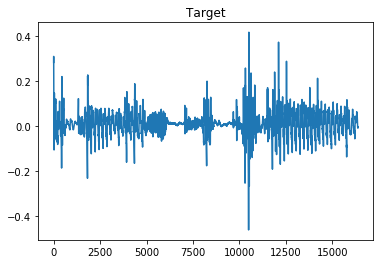

In [82]:
plt.figure()
plt.title('Target')
plt.plot(target)

Audio(target, rate=16000)

Reference sound clip:

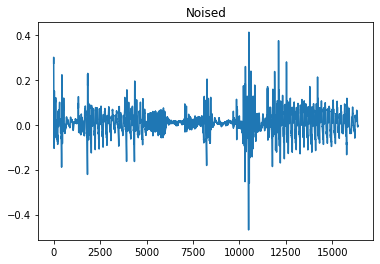

In [83]:
plt.figure()
plt.title('Noised')
plt.plot(noised)

Audio(noised, rate=16000)

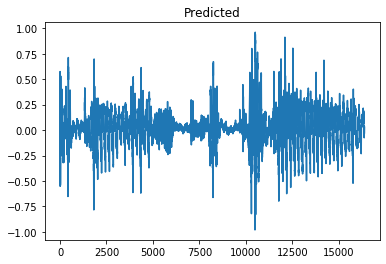

In [84]:
plt.figure()
plt.title('Predicted')
plt.plot(ref)

Audio(ref, rate=16000)

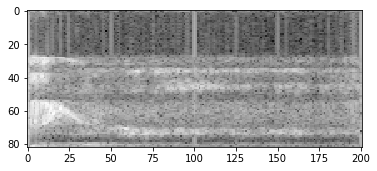

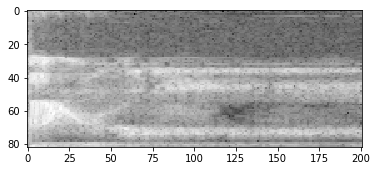

In [57]:
specgram = torchaudio.transforms.Spectrogram()(torch.tensor(ref).T)
plt.figure()
plt.imshow(specgram.T.log2().numpy()

specgram = torchaudio.transforms.Spectrogram()(torch.tensor(target).T)
plt.figure()
plt.imshow(specgram.T.log2().numpy())

## Conclusions

The network denoises rather poorly.

The PESQ metric (computes how well the model denoises speech - bound in [-0.5;4.5]) is **~2.7** (2.16 in the paper).

Note: this is a rather fake result as it is achieved by overfitting one batch. Yet, the results still seem to have a disturbing amount of noise.

Ideas for better results:
- Reduce window size to 20-50ms
- Reduce filter sizes (or try dynamic ones)
- Try out different attention mechanisms
- Try different loss functions
- Keep on experimenting!